### Republic Of Ireland Milk Sales

Milk Sales (Dairy) for Human Consumption (Million Litres) by Month and Type of Milk
- Data retrived from https://data.gov.ie/dataset/milk-sales-dairy-for-human-consumption-million-litres-by-month-and-type-of-milk
- Landing page http://www.cso.ie/px/pxeirestat/Statire/SelectVarVal/Define.asp?maintable=AKM02&PLanguage=0

First is an import of packages that will be used.

In [1]:
#Imports and Setup
import pandas as pd, numpy as np, statsmodels.api as sm, seaborn as sns
import matplotlib.pyplot as plt, matplotlib.patches as mpatches, matplotlib.dates as dates
from fbprophet import Prophet
from IPython.display import HTML, display
from statsmodels.formula.api import ols
%matplotlib inline
#hide warnings for show
import warnings
warnings.filterwarnings('ignore')

Read the csv file generated from the psx file by the accompaning R notebook into a data frame

In [2]:
#Read cvs file into a data frame
dfmilk= pd.read_csv("./data/AKM02.csv")

We see monthly data of sales of the different types of milk

In [3]:
dfmilk.tail()

,Unnamed: 0,Type.of.Milk,Month,value
2255,2256,All Milk,2017M08,45.2
2256,2257,Whole Milk,2017M08,27.4
2257,2258,Skimmed and Semi-skimmed milk,2017M08,17.8
2258,2259,Skimmed Milk,2017M08,1.7
2259,2260,Semi-skimmed milk,2017M08,16.1


Next:
- Remove the index column created in the export to csv from R.
- Rename columns 
- Cleanse the date column of the M character before converting to type datetime

In [4]:
del dfmilk['Unnamed: 0']
dfmilk.rename(columns={'Type.of.Milk': 'Type', 'Month': 'Date' }, inplace=True)
dfmilk['Date']  = dfmilk['Date'].str.replace('M','')

- Change column to datetime type
- Use end of month day for transforming from year month number
- Set date column as the data frame index

In [5]:
dfmilk['Date'] = pd.to_datetime(dfmilk['Date'], format='%Y%m')
dfmilk.Date = dfmilk.Date + pd.offsets.MonthEnd(0)
dfmilk.index = dfmilk.Date

Take a random sample to see how the data looks now

In [104]:
dfmilk.sample(3)

,Type,Date,value
Date,,,
1998-02-28,Whole Milk,1998-02-28,33.70
2009-04-30,Skimmed and Semi-skimmed milk,2009-04-30,12.44
2002-09-30,All Milk,2002-09-30,44.40


A plot shows how over the years as Skimmed and Semi-skimmed milk sales have increased, Whole milk sales have decreased.

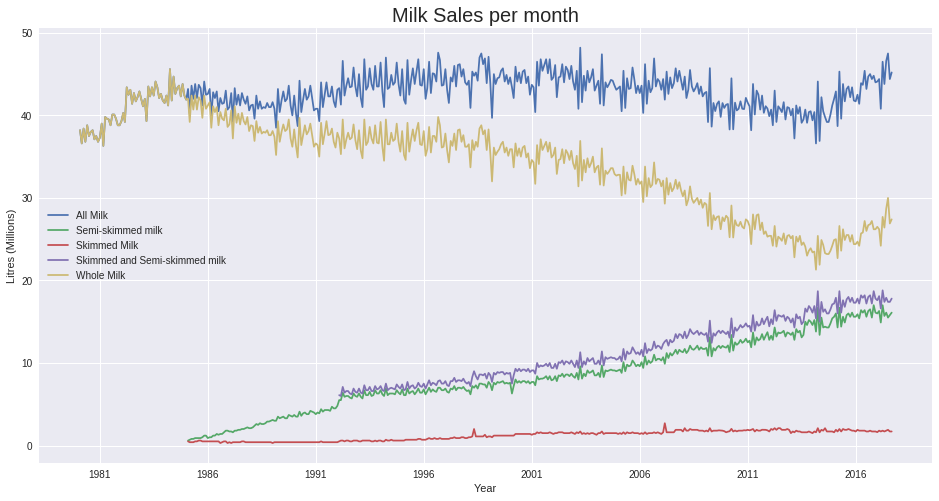

In [7]:
# Plot a graph with a line for each milk type
plt.figure(figsize=(16, 8))
for key, grp in dfmilk.groupby('Type'):
    plt.plot(grp['value'], label=key)
plt.title("Milk Sales per month", fontsize = 20) 
plt.xlabel("Year")    
plt.ylabel("Litres (Millions)")    
plt.legend(loc='best')     
plt.show()

For easy of use we create a pivot table with seperate columns for each milk type.

In [8]:
# Create a pivot table to work with
milkpvt = dfmilk.pivot(index="Date", columns="Type", values="value")

# Reduce column names to one word for ease of use
milkpvt.rename(columns={"All Milk": 'All',
                        "Semi-skimmed milk": 'Semi',
                        "Skimmed Milk": 'Skimmed',
                        "Skimmed and Semi-skimmed milk": 'SkimmedandSemi',
                        "Whole Milk": 'Whole'                        
                       }, inplace=True)

We can see some stats about the millions of litres of milk sold of each different type in a year. For example 2016 

In [9]:
milkpvt['2016'].describe()

Type,All,Semi,Skimmed,SkimmedandSemi,Whole
count,12.000000,12.000000,12.000000,12.000000,12.000000
mean,43.925000,16.100000,1.751667,17.833333,26.100000
std,1.125833,0.461224,0.076495,0.471619,0.918497
min,41.400000,15.400000,1.620000,17.200000,24.200000
25%,43.575000,15.825000,1.700000,17.500000,25.775000
50%,44.050000,16.100000,1.750000,17.850000,26.200000
75%,44.725000,16.400000,1.800000,18.200000,26.725000
max,45.400000,17.000000,1.900000,18.700000,27.200000


# Bivariate Comparison

The "Skimmed and Semi-skimmed milk" column is empty before 1992 but we can populate some values for the column by summing the "Skimmed Milk" and "Semi-skimmed milk" columns.

In [10]:
# Update SkimmedandSemi column where it is null
milkpvt.loc[milkpvt['SkimmedandSemi'].isnull(), 'SkimmedandSemi'] = milkpvt['Skimmed'] + milkpvt['Semi']

Focusing on just "Whole" milk and "Skimmed and Semi-skimmed" milk columns we can produce a boxplot of sales of milk types for each year

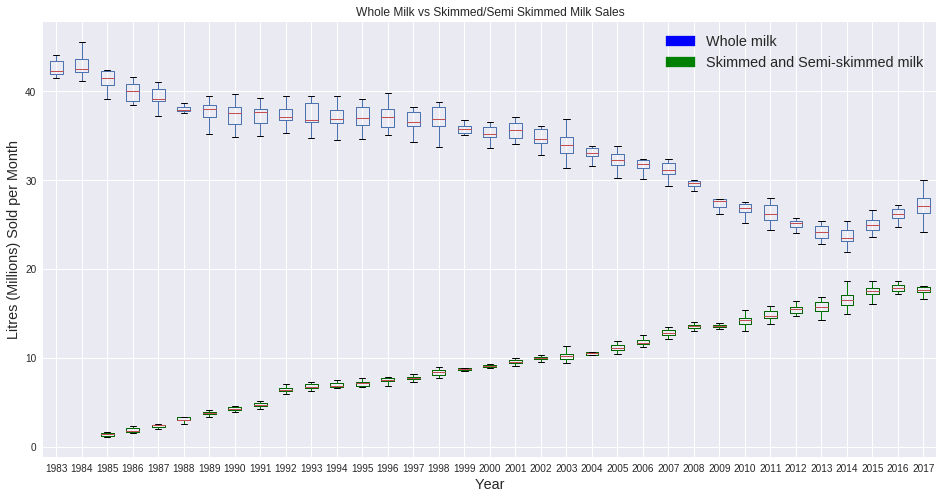

In [105]:
fig,ax = plt.subplots(figsize=(16,8))

#Set up title, label and legend
ax.set_title('Whole Milk vs Skimmed/Semi Skimmed Milk Sales')
ax.set_xlabel('Year', fontsize='large'), ax.set_ylabel('Litres (Millions) Sold per Month', fontsize='large')
blue_patch = mpatches.Patch(color='blue', label='Whole milk')
green_patch = mpatches.Patch(color='green', label='Skimmed and Semi-skimmed milk')
plt.legend(handles=[blue_patch,green_patch],  fontsize='large')

#Plot only values after 83 to reduce plot size
milkpvt = milkpvt['1983':]

#Plot boxplots of Whole and Skimmed an Semi-skimmed columns for each year
milkpvt.set_index([milkpvt.index,milkpvt.index.year]).Whole.unstack().plot.box(ax = ax)
greencolor = dict(boxes='DarkGreen',whiskers='Green')
milkpvt.set_index([milkpvt.index,milkpvt.index.year]).SkimmedandSemi.unstack().plot.box(ax = ax, color=greencolor)

We can see that until recent years Whole milk has more variation within a year as the boxplots are larger compared to the tight boxes of Skimmed and Semi-skimmed. It could be that whole milk was more affected by seasonal changes.

Further plots show the distribution of the sales of milk types and the relationship between these

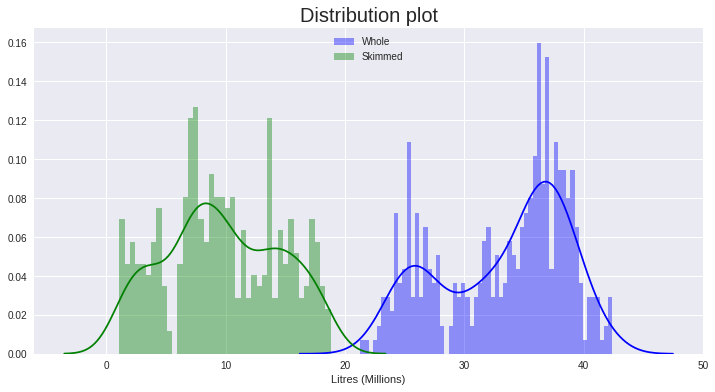

In [12]:
sns.set(rc={"figure.figsize": (12, 6)})
sns.distplot(milkpvt['1985':].Whole,bins=60,color='blue', label='Whole');
sns.distplot(milkpvt['1985':].SkimmedandSemi,bins=40,color='green', label='Skimmed');
plt.title('Distribution plot' , fontsize = 20)
plt.xlabel("Litres (Millions)")
plt.legend(loc=9);

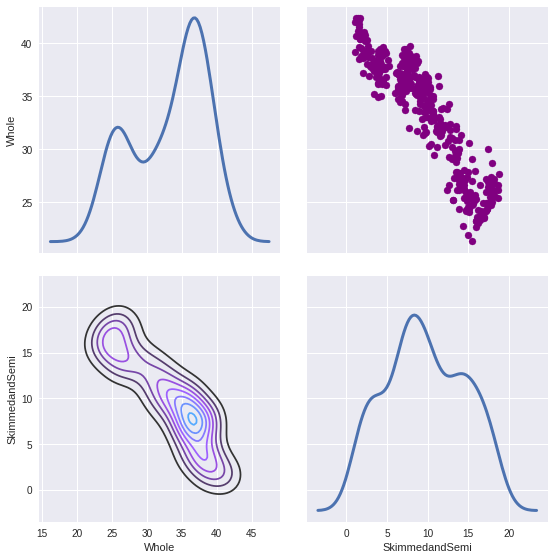

In [106]:
returns_fig=sns.PairGrid(milkpvt[['Whole','SkimmedandSemi']]['1985':], size=4)
returns_fig.map_upper(plt.scatter,color='purple')
returns_fig.map_lower(sns.kdeplot,cmap='cool_d')
returns_fig.map_diag(sns.kdeplot, lw=3, legend=False)

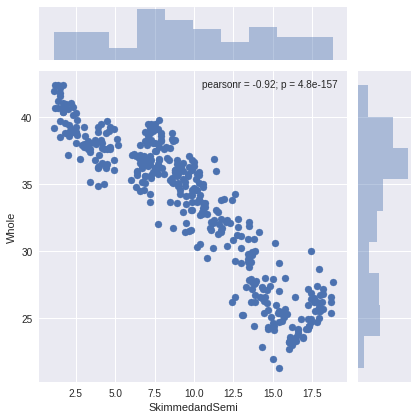

In [14]:
sns.jointplot(milkpvt.SkimmedandSemi,milkpvt.Whole)

The pearsonr value of -0.92 shows an inverse relationalship between sales of Whole milk and Skimmed/Semiskimmed milk.

##  Ordinary Least Squares Analysis

In [15]:
milk_model = ols("Whole ~ SkimmedandSemi", data=milkpvt).fit()

In [16]:
milk_model_summary = milk_model.summary()
HTML(
milk_model_summary\
.as_html()
)

The Ordinary Least Squares coefficient of -1.01 for Skimmed and Semi-skimmed milk against Whole milk indicate that for each extra litre of whole purchased there is an equivlent decrease of one litre of Skimmed and Semi-skimmed milk purchases which could be explained by people making a choice between the two.

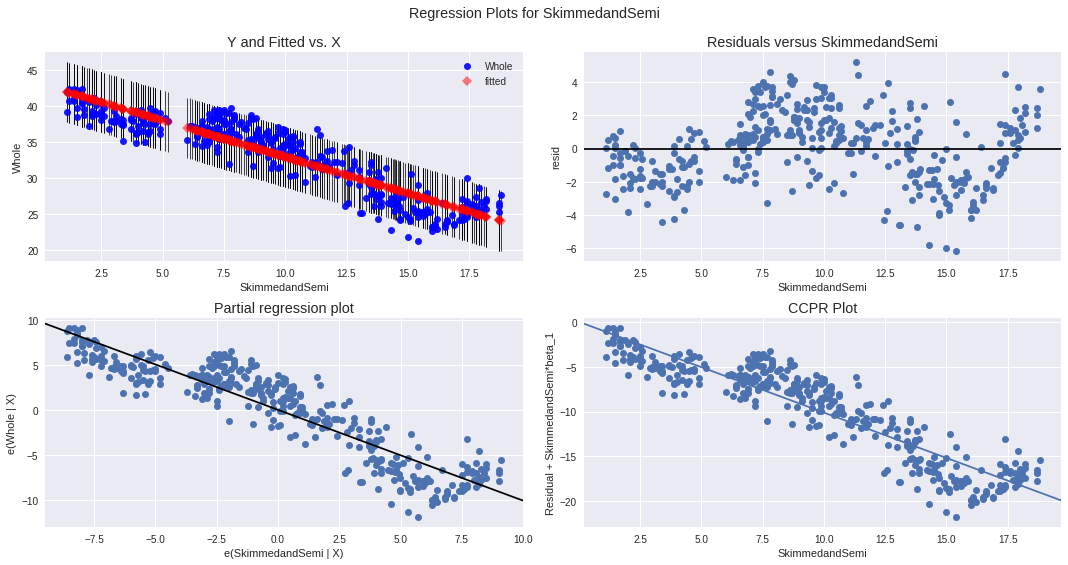

In [17]:
fig = plt.figure(figsize=(15,8))

# pass in the model as the first parameter, then specify the 
# predictor variable we want to analyze
fig = sm.graphics.plot_regress_exog(milk_model, "SkimmedandSemi", fig=fig)

# Predict future all milk sales with Prophet

We can predict the sales of the combined sales of all milk types with Prophet.
 - Make a dataframe of just the All Milk values
 - change column names to y and ds as required by Prophet
 - Remove the type column as just "All Milk" is left

In [18]:
almilk = dfmilk[dfmilk['Type'] == 'All Milk']
almilk.rename(columns={ 'value': 'y','Date': 'ds' }, inplace=True)
del almilk['Type']

In [19]:
almilk.tail(2)

,ds,y
Date,,
2017-07-31,2017-07-31,44.4
2017-08-31,2017-08-31,45.2


Create Prophet model using data from 1982 onwards

In [20]:
model = Prophet()
model.fit(almilk['1982':])

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [21]:
future = model.make_future_dataframe(periods=48, freq='MS')

In [22]:
forecast = model.predict(future)

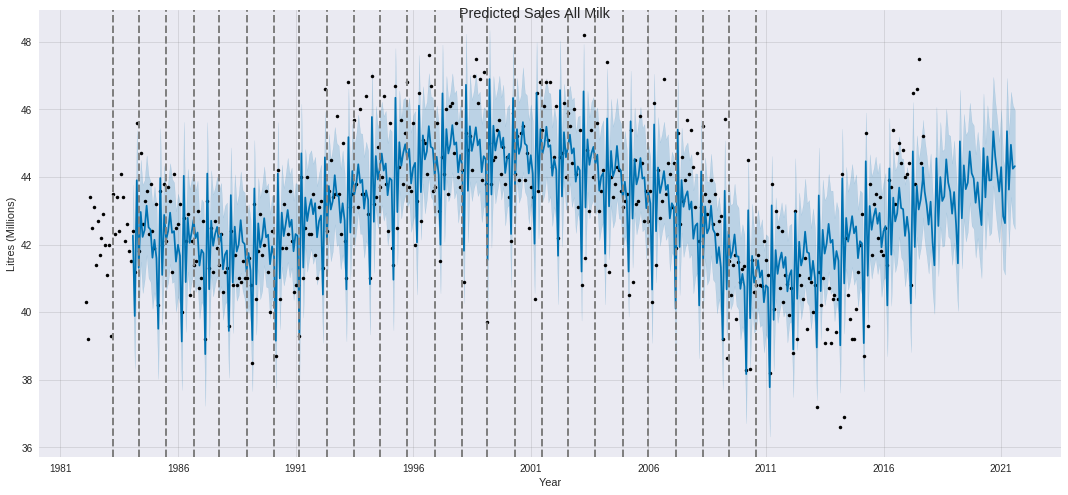

In [23]:
fig, ax = plt.subplots(figsize=(15,7))

model.plot(forecast.where(forecast.ds > '1984'), xlabel="Year",ylabel="Litres (Millions)", ax=ax)
for cp in model.changepoints:
    plt.axvline(cp, c='gray', ls='--', lw=2)
fig.suptitle('Predicted Sales All Milk')
fig.tight_layout()

The changepoints automatically generated by Prophet represented by dotted lines above stop after 2011. This does not appear to include a potenial changepoint in 2014 after which the sales stop a downward trend and start to increase. 

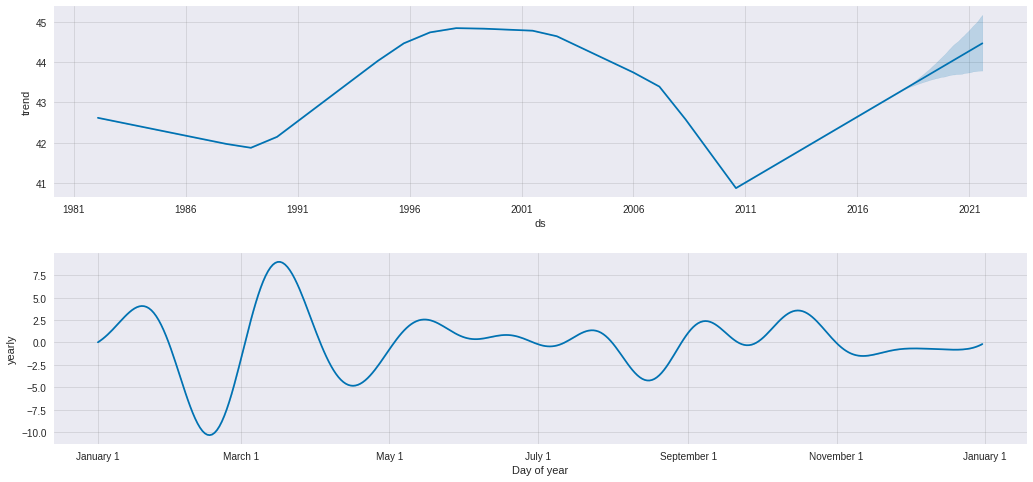

In [24]:
ax = model.plot_components(forecast)
ax.set_figheight(7)
ax.set_figwidth(15)

To see if we get a different prediction with a changepoint in 2014 we can manually set some changepoints at two year intervals to span the series.

In [25]:
mdlman = Prophet(changepoints=pd.date_range(start='1983-1-1', periods=34, freq='A'))
mdlman.fit(almilk['1982':])

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [26]:
ftrman = mdlman.make_future_dataframe(periods=48, freq='MS')

frcast = mdlman.predict(ftrman)

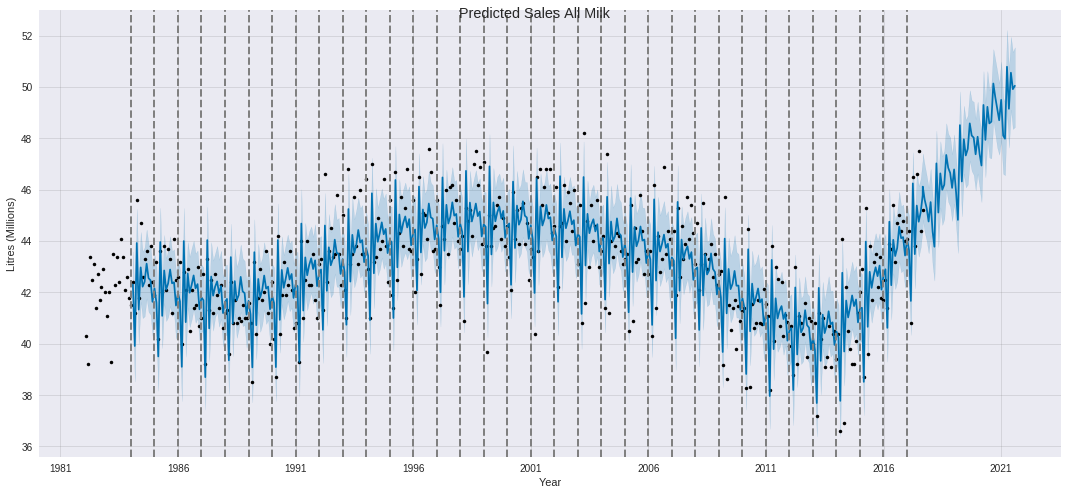

In [27]:
fig, ax = plt.subplots(figsize=(15,7))

mdlman.plot(frcast.where(frcast.ds > '1984'), xlabel="Year",ylabel="Litres (Millions)", ax=ax)
for cp in mdlman.changepoints:
    plt.axvline(cp, c='gray', ls='--', lw=2)
fig.suptitle('Predicted Sales All Milk')
fig.tight_layout()

To focus the plot of our forecast on just recent years we can create a model with data after 2012 and plot our previous forecast calculated from all data on it.

In [33]:
mdlshort = Prophet()
mdlshort.fit(almilk['2012':])

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


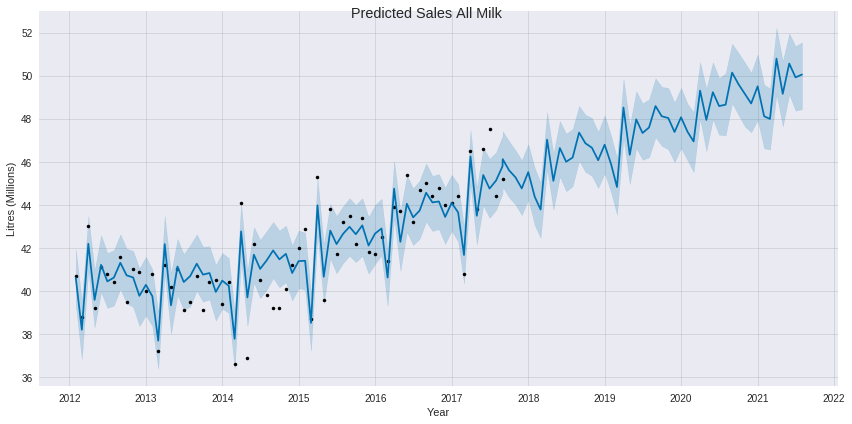

In [34]:
fig, ax = plt.subplots(figsize=(12,6))

mdlshort.plot(frcast.where(frcast.ds > '2012'), xlabel="Year",ylabel="Litres (Millions)", ax=ax)
#for cp in mdlman.changepoints:
#    plt.axvline(cp, c='gray', ls='--', lw=2)
fig.suptitle('Predicted Sales All Milk')
fig.tight_layout()

The original forecast predicts that monthly sales of milk would be around 44 million litres per month whereas the updated forecast with manually set changepoints indicate that it would reach 50 million litres if the current upward trend persists.

In [99]:
print('Forecast with automatic changepoints')
forecast[['ds','yhat_lower','yhat_upper','yhat']].tail()

Forecast with automatic changepoints


,ds,yhat_lower,yhat_upper,yhat
471,2021-04-01,43.688287,46.931774,45.355015
472,2021-05-01,41.938520,45.272213,43.627670
473,2021-06-01,43.408758,46.523738,44.954259
474,2021-07-01,42.635848,46.121660,44.245221
475,2021-08-01,42.459575,45.974923,44.320650


In [100]:
print('Forecast with manually set changepoints')
frcast[['ds','yhat_lower','yhat_upper','yhat']].tail()

Forecast with manually set changepoints


,ds,yhat_lower,yhat_upper,yhat
471,2021-04-01,49.126784,52.220723,50.790401
472,2021-05-01,47.641930,50.675811,49.153726
473,2021-06-01,49.120780,51.957469,50.559226
474,2021-07-01,48.368164,51.361653,49.918016
475,2021-08-01,48.440292,51.547476,50.050260


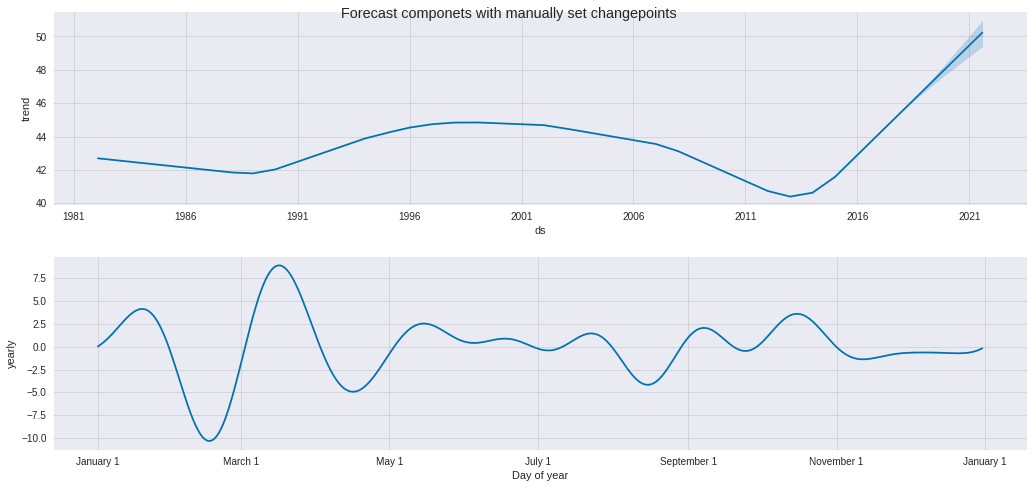

In [103]:
fig = mdlman.plot_components(frcast)
fig.suptitle("Forecast componets with manually set changepoints")
fig.set_figheight(7)
fig.set_figwidth(15)

The updated trend shows a peak for all milk sales around 2000 followed by a decreased until 2014 and a consistent increase since.

In the yearly component we see the month that usually has the higest sales is March with the lowest sales in Febuary and April. To check the yearly seasonality above we can plot the last few years to confirm if they follow a similar pattern.

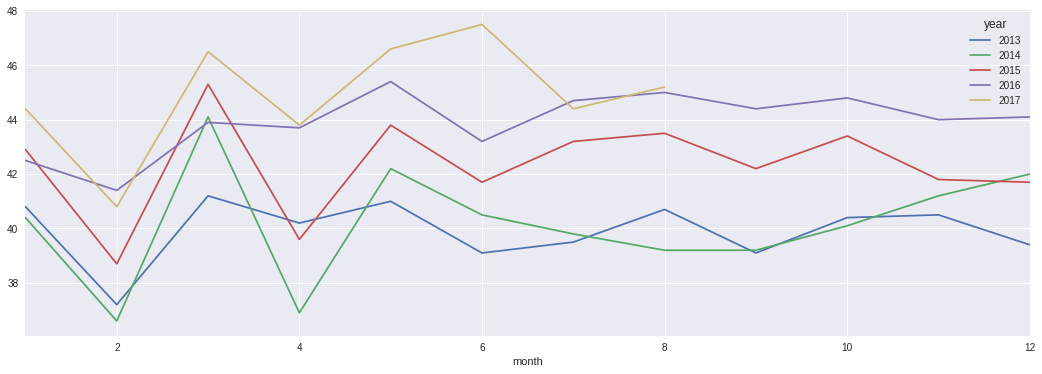

In [96]:
milkpvt['month'] = milkpvt.index.month
milkpvt['year'] = milkpvt.index.year
mntmlk = milkpvt['2013':].pivot_table(index=milkpvt.month, columns=milkpvt.year, values="All")

fig, ax = plt.subplots(figsize=(18,6))
mntmlk.plot(legend="best", ax=ax)